<a href="https://colab.research.google.com/github/Dor-Nachbi/DCGAN_LSGAN/blob/master/This_Fish_Doesn't_Exist_LSGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#We've compressed the processed images to .pkl file in order to save the long loading time.
#The compressed file can be found here https://drive.google.com/file/d/1UQ1f8PQfL3v6Hm1leT2JNPEXiKHrc9_b/view?usp=sharing

from __future__ import absolute_import, division, print_function, unicode_literals
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Model, Input
from google.colab import drive
import matplotlib.pyplot as plt
import pickle
import numpy as np
import time
import os

tf.__version__


'2.2.0-rc3'

 **Load and prepare the dataset**

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
there are  4457 images
load time is: 72.62582325935364
data loaded, shuffled and split to 70 batches
(140, 320, 3)


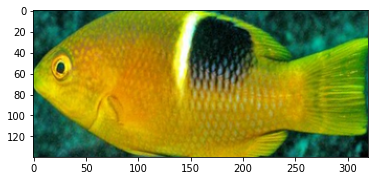

In [0]:

drive.mount('/content/drive/')

BATCH_SIZE = 64
IMG_HEIGHT = 140
IMG_WIDTH = 320
IMG_CHANNELS = 3
NOISE_SIZE = 512
EPOCHS = 1000
images_path = '/content/drive/My Drive/resize/images.pkl'
output_directory = '/content/drive/My Drive/images'
sample_imgs_path = output_directory + '/generated_images'
graph_path = output_directory + '/loss_graphs'
models_save_path = output_directory + '/models'
disc_save_name = '/discriminator.h5'
gen_save_name = '/generator.h5'
conv_time = time.time()

# the fish images normalized between 1 and -1
with open(images_path, 'rb') as input:
    images = pickle.load(input)

n_images = len(images)

print('there are ', n_images, 'images')
print('load time is: {}'.format(time.time() - conv_time))

dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(n_images).batch(BATCH_SIZE)

n_batch = int(np.ceil(n_images / BATCH_SIZE))

print('data loaded, shuffled and split to {} batches'.format(n_batch))

sample = next(dataset.as_numpy_iterator())[0]
print(sample.shape)
plt.imshow((sample + 1) / 2)
plt.show()


**Optimizers & Params**

In [0]:
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = 0.5 * tf.reduce_mean((real_output - tf.ones_like(real_output)) ** 2)
    fake_loss = 0.5 * tf.reduce_mean(fake_output ** 2)
    return real_loss, fake_loss


@tf.function
def generator_loss(output): 
    return 0.5 * tf.reduce_mean((output - tf.ones_like(output)) ** 2)


# Gaussian Weight Initialization
init_disc = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)
init_gen = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)


**The Discriminator**

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.GaussianNoise(0.05,input_shape=[140, 320, 3]))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            kernel_initializer='glorot_normal'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(5, 5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model._name = 'discriminator'
    model.summary()
    img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    validity = model(img)
    return Model(img, validity)


**Create Discriminator**

In [0]:
if os.path.exists(models_save_path + disc_save_name):
    discriminator = load_model(models_save_path + disc_save_name)
    print("Loaded discriminator...")
else:
    discriminator = make_discriminator_model()
    print("Generated discriminator")

Loaded discriminator...


**The Generator**

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 16 * 512, use_bias=False, input_shape=(NOISE_SIZE,)))

    model.add(layers.Reshape((7, 16, 512)))
    assert model.output_shape == (None, 7, 16, 512)

    model.add(layers.Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False,
                                     kernel_initializer=init_gen))
    assert model.output_shape == (None, 7, 16, 256)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, 35, 80, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 35, 80, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 70, 160, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 70, 160, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 140, 320, 3)

    model._name = 'generator'
    model.summary()
    noise = Input(shape=(NOISE_SIZE,))
    img = model(noise)
    return Model(noise, img)


**Create Generator**

In [0]:
if os.path.exists(models_save_path + gen_save_name):
    generator = load_model(models_save_path + gen_save_name, custom_objects={'LeakyReLU': layers.LeakyReLU(0.2)})
    print("Loaded generator...")
else:
    generator = make_generator_model()
    print("Generated generator")


Loaded generator...


**Train Functions**

In [0]:
@tf.function
def train_step(images):
    batch_size = images.shape[0]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # ----- Train Discriminator -----
        noise = tf.random.normal([batch_size, NOISE_SIZE])
        fake_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(fake_images, training=True)
        d_real_loss, d_fake_loss = discriminator_loss(real_output=real_output, fake_output=fake_output)
        gradients_of_discriminator = disc_tape.gradient(d_real_loss + d_fake_loss,
                                                        discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables))

        # ----- Train Generator -----
        noise = tf.random.normal([batch_size, NOISE_SIZE])
        fake_images = generator(noise, training=True)
        disc_on_fake = discriminator(fake_images, training=True)
        g_loss = generator_loss(disc_on_fake)
        gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return d_real_loss, d_fake_loss, g_loss


# randomly flip some labels
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * int(y.shape[0]))
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)

    op_list = []
    # invert the labels in place
    # y_np[flip_ix] = 1 - y_np[flip_ix]
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(1 - y[i])
        else:
            op_list.append(y[i])

    outputs = tf.stack(op_list)
    return outputs


def generate_noise(n_samples, n_size):
    x = np.random.randn(n_samples * n_size)
    return np.reshape(x, (n_samples, n_size))
    

**Train**

In [0]:
def sample_image(epoch):
    noise = generate_noise(1, NOISE_SIZE)

    sample_img = generator(noise)[0]
    # Rescale images 0 - 1
    sample_img = 0.5 * sample_img + 0.5
    f = plt.figure()
    plt.imshow(sample_img)
    plt.axis('off')

    if not os.path.exists(sample_imgs_path):
        os.makedirs(sample_imgs_path)
    plt.show()
    f.savefig(sample_imgs_path + '/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()



def save_models(gen, disc, path):
    if not os.path.exists(path):
        os.makedirs(path)
    disc.save(path + disc_save_name)
    gen.save(path + gen_save_name)


def plot_losses(g_loss, d_loss, epoch):
    f = plt.figure()
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss Magnitude')
    plt.plot(list(range(1, len(g_loss) + 1)), g_loss, color='blue', label='generator')
    plt.plot(list(range(1, len(d_loss) + 1)), d_loss, color='red', label='discriminator')
    plt.legend(loc='upper right')
    plt.show()
    f.savefig(graph_path + '/losses_eopch_{:04d}.png'.format(epoch))
    plt.close()

def train(dataset, epochs):
    sample_epoch = 20
    save_epoch = 10

    g_losses_epoch = []
    d_losses_epoch = []
    for epoch in range(epochs):
        print('start epoch {}'.format(epoch + 1))
        start = time.time()
        # shuffle the dataset
        dataset.shuffle(n_images).batch(BATCH_SIZE)
        g_losses = []
        d_real_losses = []
        d_fake_losses = []

        for i, image_batch in enumerate(dataset):
            d_real_loss, d_fake_loss, g_loss = train_step(image_batch)

            d_real_losses.append(np.mean(d_real_loss))
            d_fake_losses.append(np.mean(d_fake_loss))
            g_losses.append(np.mean(g_loss))

        epoch_g_loss = np.float(np.mean(g_losses))
        epoch_d_real_loss = np.float(np.mean(d_real_losses))
        epoch_d_fake_loss = np.float(np.mean(d_fake_losses))
        epoch_d_loss = (epoch_d_real_loss + epoch_d_fake_loss) / 2
        print('epoch: %d [D real loss: %f] [D fake loss: %f] [D mean loss: %f] [G loss: %f]' % (
            epoch + 1, epoch_d_real_loss, epoch_d_fake_loss, epoch_d_loss,
            epoch_g_loss))
        g_losses_epoch.append(epoch_g_loss)
        d_losses_epoch.append(epoch_d_loss)
        if (epoch + 1) % save_epoch == 0:
            save_models(generator, discriminator, models_save_path)
            print('saved models in epoch: {}'.format(epoch + 1))
        if (epoch + 1) % sample_epoch == 0:
            plot_losses(g_losses_epoch, d_losses_epoch, epoch + 1)
            print('fish in epoch: {}'.format(epoch + 1))
            sample_image(epoch + 1)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))


train(dataset, EPOCHS)
